Лабораторная работа №5

Импортируем библиотеки

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms


Извлекаем пути к изображениям из csv файла

In [3]:
dframe = pd.read_csv(
    "K:/Pyth/PLab1/Lab2/annotation.csv", delimiter=",", names=["Absolute Path", "Relative Path", "Class"]
)
img_list=dframe["Absolute Path"].tolist()
random.shuffle(img_list)
print(img_list[:5])

['K:\\Pyth\\PLab1\\dataset\\polar_bear\\0864.jpg', 'K:\\Pyth\\PLab1\\dataset\\polar_bear\\0722.jpg', 'K:\\Pyth\\PLab1\\dataset\\polar_bear\\0944.jpg', 'K:\\Pyth\\PLab1\\dataset\\polar_bear\\0386.jpg', 'K:\\Pyth\\PLab1\\dataset\\brown_bear\\0163.jpg']


Получаем метки класса

In [4]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['polar_bear', 'polar_bear', 'polar_bear', 'polar_bear', 'brown_bear']


Разделяем список изображений на тренировочный, тестовый и валидационный

In [5]:
train_list = img_list[0 : int(len(img_list) * 0.8)]
test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]
print(len(train_list ))
print(len(test_list))
print(len(val_list))

1600
200
200


Проверяем картинки

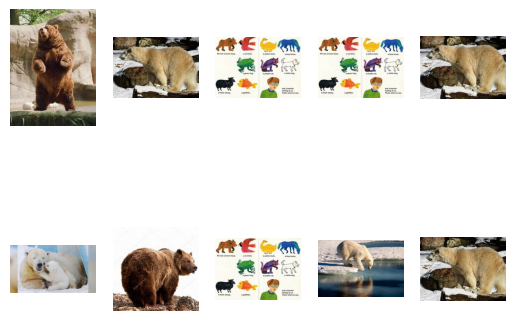

In [6]:
random_idx = np.random.randint(1,len(img_list),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')


plt.show()

Определяем класс Dataset, хранящий преобразованные изображения

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform


    def __len__(self):
        return len(self.file_list)


    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = os.path.basename(os.path.dirname(img_path))
        label = 0 if label == "brown_bear" else 1
        return img_transformed, label

Пайплайн

In [8]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = Dataset(train_list, transform=fixed_transforms)
test_data = Dataset(test_list, transform=fixed_transforms)
val_data = Dataset(val_list, transform=fixed_transforms)

In [9]:
print(len(train_data))
train_data[0][0].shape

1600


torch.Size([3, 224, 224])

Класс CNN построения модели

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(3 * 3 * 16, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1234)
if device == "cuda":
    torch.cuda.manual_seed_all(1234)
model = CNN()
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Отображаем графики

In [12]:
def show_results(epochs, acc, loss, v_acc, v_loss) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="green", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="green", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="blue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="blue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show()

Процесс обучения

In [13]:
def training(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Запуск

Epoch : 1, train accuracy : 0.8843750357627869, train loss : 0.4170885980129242
Epoch : 1, val_accuracy : 0.9500000476837158, val_loss : 0.2226208597421646
Epoch : 2, train accuracy : 0.948124885559082, train loss : 0.17173679172992706
Epoch : 2, val_accuracy : 0.9550000429153442, val_loss : 0.14671118557453156
Epoch : 3, train accuracy : 0.9668750166893005, train loss : 0.11623391509056091
Epoch : 3, val_accuracy : 0.9600000381469727, val_loss : 0.1320028454065323
Epoch : 4, train accuracy : 0.9668749570846558, train loss : 0.09457768499851227
Epoch : 4, val_accuracy : 0.9750000238418579, val_loss : 0.08583644777536392
Epoch : 5, train accuracy : 0.9749999046325684, train loss : 0.07565455883741379
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.08531931787729263
Epoch : 6, train accuracy : 0.9774999022483826, train loss : 0.06285916268825531
Epoch : 6, val_accuracy : 0.9850000143051147, val_loss : 0.07526133209466934
Epoch : 7, train accuracy : 0.9787501096725464, train lo

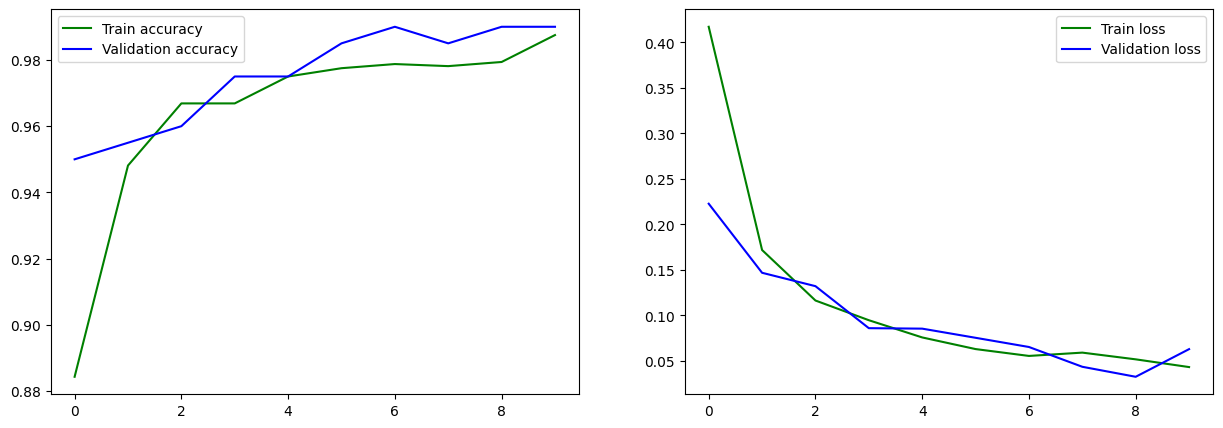

In [14]:
training(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9606249928474426, train loss : 0.1156662330031395
Epoch : 1, val_accuracy : 0.9550000429153442, val_loss : 0.13840585947036743
Epoch : 2, train accuracy : 0.9762500524520874, train loss : 0.0676739513874054
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.08395551145076752
Epoch : 3, train accuracy : 0.9781249165534973, train loss : 0.06850932538509369
Epoch : 3, val_accuracy : 0.9850000143051147, val_loss : 0.06410323828458786
Epoch : 4, train accuracy : 0.9806249141693115, train loss : 0.07115096598863602
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.04807320609688759
Epoch : 5, train accuracy : 0.9849998950958252, train loss : 0.047346167266368866
Epoch : 5, val_accuracy : 0.9900000095367432, val_loss : 0.055520132184028625
Epoch : 6, train accuracy : 0.9887499213218689, train loss : 0.03608467057347298
Epoch : 6, val_accuracy : 0.9900000095367432, val_loss : 0.03834779933094978
Epoch : 7, train accuracy : 0.9868749380111694, trai

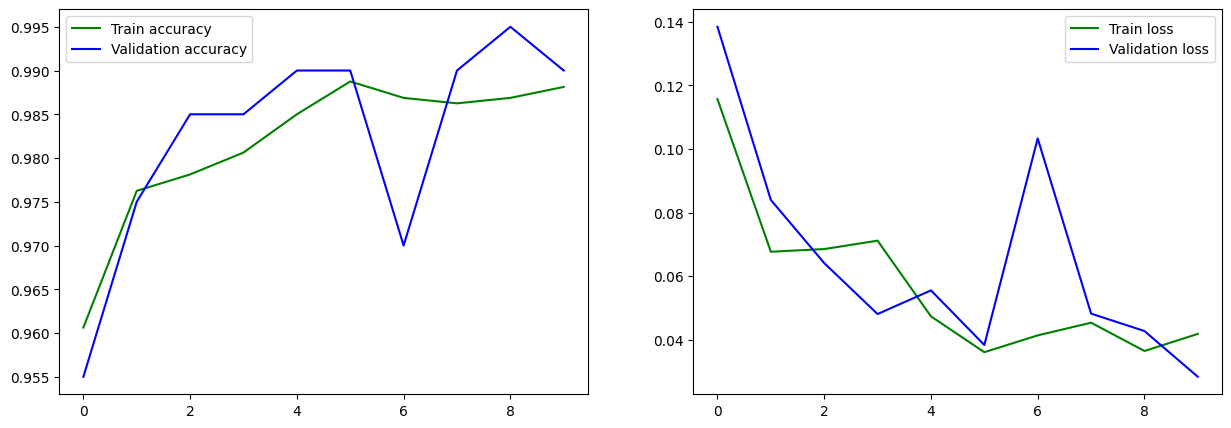

In [15]:
training(10, 100, 0.005)

Epoch : 1, train accuracy : 0.9843748807907104, train loss : 0.05781569331884384
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.045867227017879486
Epoch : 2, train accuracy : 0.9837499856948853, train loss : 0.05459107458591461
Epoch : 2, val_accuracy : 0.9900000095367432, val_loss : 0.0579206719994545
Epoch : 3, train accuracy : 0.9856249094009399, train loss : 0.043291520327329636
Epoch : 3, val_accuracy : 0.9800000190734863, val_loss : 0.04787242412567139
Epoch : 4, train accuracy : 0.9825000762939453, train loss : 0.05715584382414818
Epoch : 4, val_accuracy : 0.9900000095367432, val_loss : 0.04999205842614174
Epoch : 5, train accuracy : 0.9868749976158142, train loss : 0.05229944735765457
Epoch : 5, val_accuracy : 0.9800000190734863, val_loss : 0.0415312834084034
Epoch : 6, train accuracy : 0.981874942779541, train loss : 0.05272531136870384
Epoch : 6, val_accuracy : 0.9750000238418579, val_loss : 0.04699479043483734
Epoch : 7, train accuracy : 0.9843749403953552, train

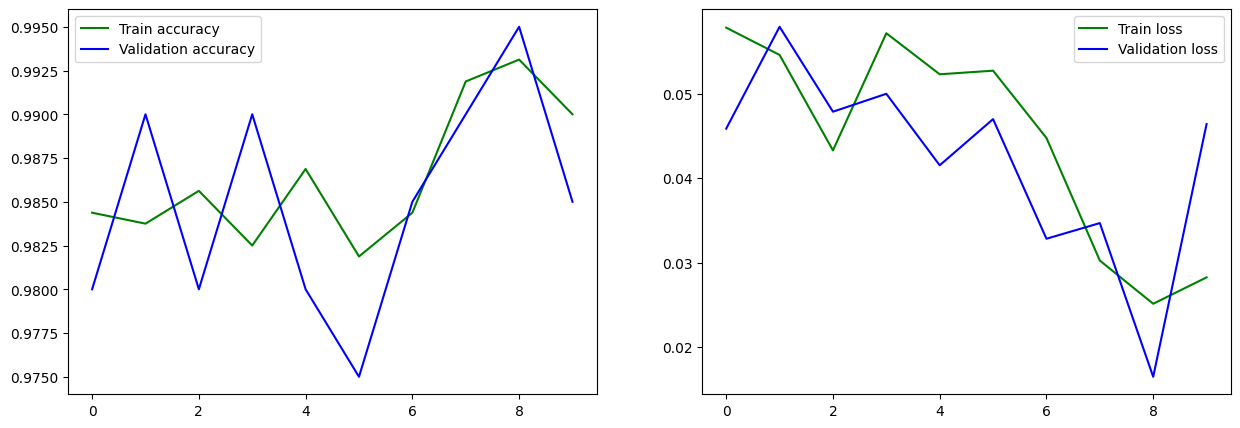

In [16]:
training(10, 100, 0.007)

Epoch : 1, train accuracy : 0.9862500429153442, train loss : 0.0425427071750164
Epoch : 1, val_accuracy : 0.9750000238418579, val_loss : 0.0876641646027565
Epoch : 2, train accuracy : 0.9924999475479126, train loss : 0.03315960615873337
Epoch : 2, val_accuracy : 0.9950000047683716, val_loss : 0.015515420585870743
Epoch : 3, train accuracy : 0.9912500381469727, train loss : 0.02037021331489086
Epoch : 3, val_accuracy : 1.0, val_loss : 0.009839365258812904
Epoch : 4, train accuracy : 0.9893749952316284, train loss : 0.020897123962640762
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.021680405363440514
Epoch : 5, train accuracy : 0.9937499761581421, train loss : 0.0185678843408823
Epoch : 5, val_accuracy : 0.9850000143051147, val_loss : 0.03434747830033302
Epoch : 6, train accuracy : 0.9931249618530273, train loss : 0.020642483606934547
Epoch : 6, val_accuracy : 1.0, val_loss : 0.006239612121134996
Epoch : 7, train accuracy : 0.9918749332427979, train loss : 0.0213119685649871

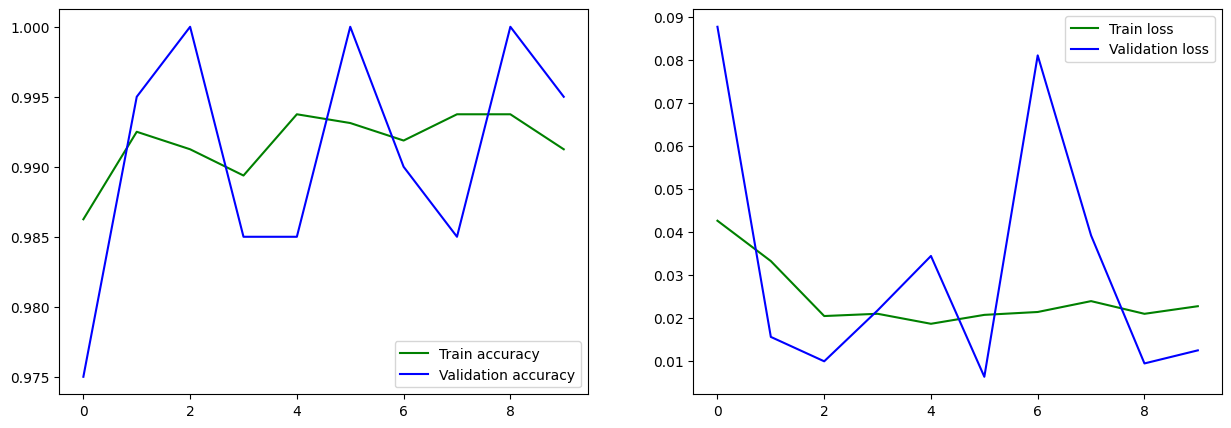

In [17]:
training(10, 200, 0.001)

Epoch : 1, train accuracy : 0.986875057220459, train loss : 0.034072209149599075
Epoch : 1, val_accuracy : 0.9950000047683716, val_loss : 0.026760263368487358
Epoch : 2, train accuracy : 0.9906249046325684, train loss : 0.03590456768870354
Epoch : 2, val_accuracy : 1.0, val_loss : 0.01645972765982151
Epoch : 3, train accuracy : 0.9937499761581421, train loss : 0.020197007805109024
Epoch : 3, val_accuracy : 0.9900000095367432, val_loss : 0.020606331527233124
Epoch : 4, train accuracy : 0.9893749952316284, train loss : 0.03069372847676277
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.03944024071097374
Epoch : 5, train accuracy : 0.9912500381469727, train loss : 0.028161747381091118
Epoch : 5, val_accuracy : 0.9900000095367432, val_loss : 0.022064628079533577
Epoch : 6, train accuracy : 0.9912499189376831, train loss : 0.024957576766610146
Epoch : 6, val_accuracy : 0.9950000047683716, val_loss : 0.016477223485708237
Epoch : 7, train accuracy : 0.9918749332427979, train loss :

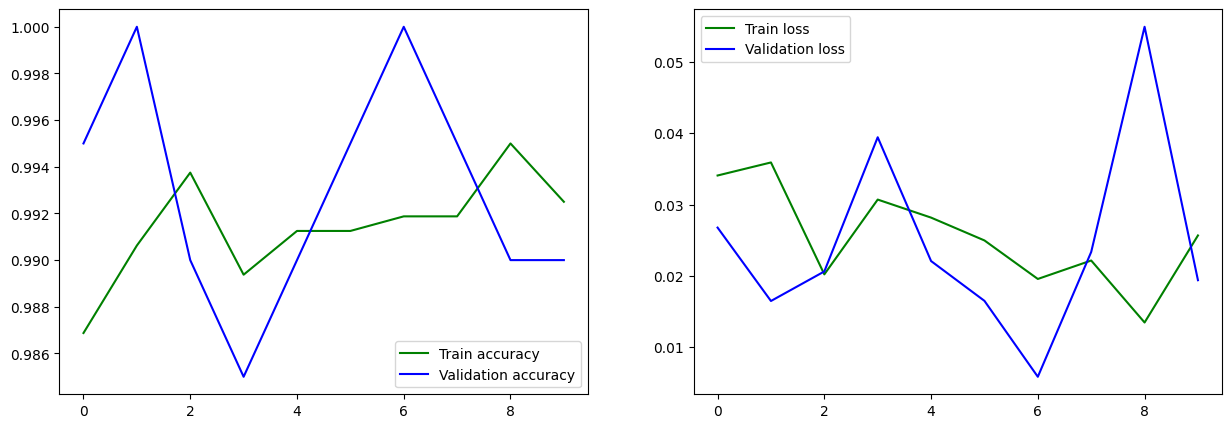

In [18]:
training(10, 200, 0.005)

Epoch : 1, train accuracy : 0.9906250238418579, train loss : 0.020612729713320732
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.06718290597200394
Epoch : 2, train accuracy : 0.9900000095367432, train loss : 0.035224638879299164
Epoch : 2, val_accuracy : 0.9900000095367432, val_loss : 0.029047448188066483
Epoch : 3, train accuracy : 0.9824999570846558, train loss : 0.04017083719372749
Epoch : 3, val_accuracy : 0.9950000047683716, val_loss : 0.022425569593906403
Epoch : 4, train accuracy : 0.9912499785423279, train loss : 0.023083996027708054
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.021505184471607208
Epoch : 5, train accuracy : 0.9924999475479126, train loss : 0.018205124884843826
Epoch : 5, val_accuracy : 0.9900000095367432, val_loss : 0.014286505989730358
Epoch : 6, train accuracy : 0.9950000047683716, train loss : 0.012700715102255344
Epoch : 6, val_accuracy : 1.0, val_loss : 0.004331236705183983
Epoch : 7, train accuracy : 0.9912500381469727, train los

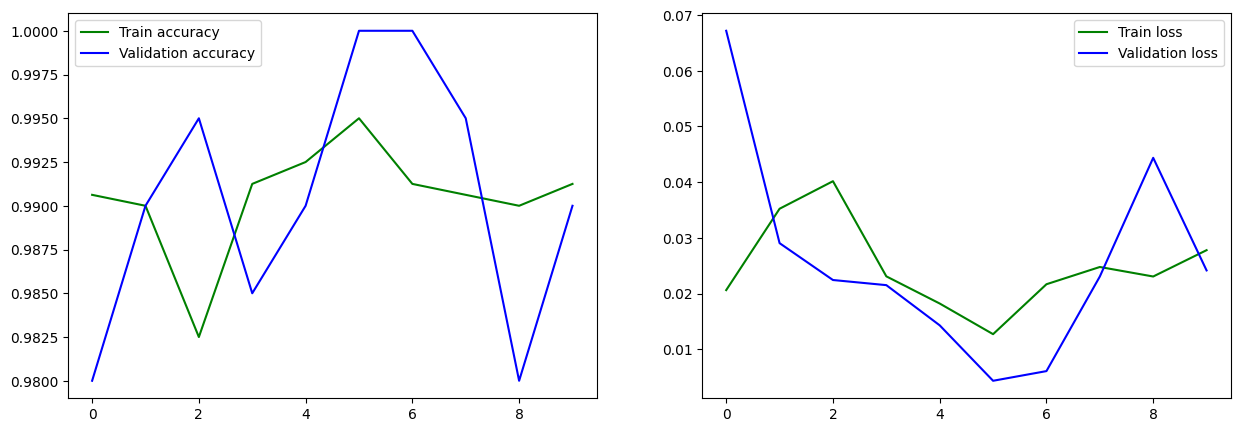

In [19]:
training(10, 200, 0.007)

Epoch : 1, train accuracy : 0.9905555844306946, train loss : 0.022212039679288864
Epoch : 1, val_accuracy : 1.0, val_loss : 0.006325694732367992
Epoch : 2, train accuracy : 0.9961111545562744, train loss : 0.01353827491402626
Epoch : 2, val_accuracy : 1.0, val_loss : 0.004113625735044479
Epoch : 3, train accuracy : 0.9911110997200012, train loss : 0.016721287742257118
Epoch : 3, val_accuracy : 1.0, val_loss : 0.009668940678238869
Epoch : 4, train accuracy : 0.9955556392669678, train loss : 0.014471946284174919
Epoch : 4, val_accuracy : 0.9900000095367432, val_loss : 0.0349859744310379
Epoch : 5, train accuracy : 0.9944444894790649, train loss : 0.017251526936888695
Epoch : 5, val_accuracy : 0.9950000047683716, val_loss : 0.10293052345514297
Epoch : 6, train accuracy : 0.9916667342185974, train loss : 0.02553011104464531
Epoch : 6, val_accuracy : 0.9950000047683716, val_loss : 0.008649825118482113
Epoch : 7, train accuracy : 0.9961111545562744, train loss : 0.014146346598863602
Epoch : 

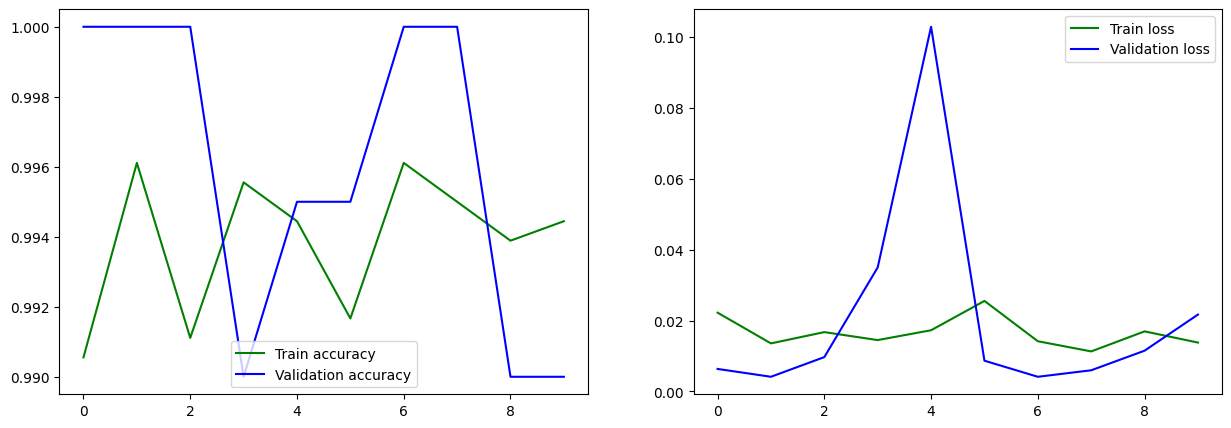

In [20]:
training(10, 300, 0.001)

Epoch : 1, train accuracy : 0.9950000643730164, train loss : 0.015486862510442734
Epoch : 1, val_accuracy : 0.9950000047683716, val_loss : 0.007208207622170448
Epoch : 2, train accuracy : 0.9950000047683716, train loss : 0.016842542216181755
Epoch : 2, val_accuracy : 0.9900000095367432, val_loss : 0.11621250957250595
Epoch : 3, train accuracy : 0.9938889145851135, train loss : 0.011452953331172466
Epoch : 3, val_accuracy : 0.9900000095367432, val_loss : 0.017113441601395607
Epoch : 4, train accuracy : 0.9872221946716309, train loss : 0.02982958033680916
Epoch : 4, val_accuracy : 1.0, val_loss : 0.00912761501967907
Epoch : 5, train accuracy : 0.9922221899032593, train loss : 0.019454175606369972
Epoch : 5, val_accuracy : 0.9950000047683716, val_loss : 0.01880732737481594
Epoch : 6, train accuracy : 0.9950000047683716, train loss : 0.0172701608389616
Epoch : 6, val_accuracy : 0.9950000047683716, val_loss : 0.013221675530076027
Epoch : 7, train accuracy : 0.9933333992958069, train loss : 

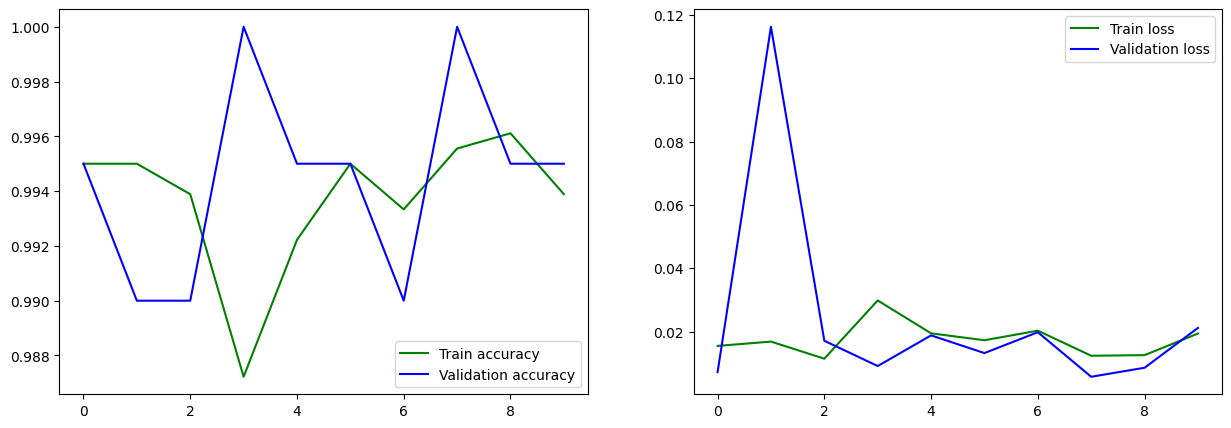

In [21]:
training(10, 300, 0.005)

Epoch : 1, train accuracy : 0.995555579662323, train loss : 0.01044839434325695
Epoch : 1, val_accuracy : 0.9900000095367432, val_loss : 0.013487241230905056
Epoch : 2, train accuracy : 0.9927778244018555, train loss : 0.018528245389461517
Epoch : 2, val_accuracy : 0.9950000047683716, val_loss : 0.007334630470722914
Epoch : 3, train accuracy : 0.9922221899032593, train loss : 0.01968228816986084
Epoch : 3, val_accuracy : 0.9950000047683716, val_loss : 0.00935013871639967
Epoch : 4, train accuracy : 0.9922223091125488, train loss : 0.027148734778165817
Epoch : 4, val_accuracy : 0.9850000143051147, val_loss : 0.050212763249874115
Epoch : 5, train accuracy : 0.9916666746139526, train loss : 0.025922147557139397
Epoch : 5, val_accuracy : 0.9900000095367432, val_loss : 0.019072990864515305
Epoch : 6, train accuracy : 0.9944444298744202, train loss : 0.01251212414354086
Epoch : 6, val_accuracy : 1.0, val_loss : 0.011960048228502274
Epoch : 7, train accuracy : 0.987777829170227, train loss : 

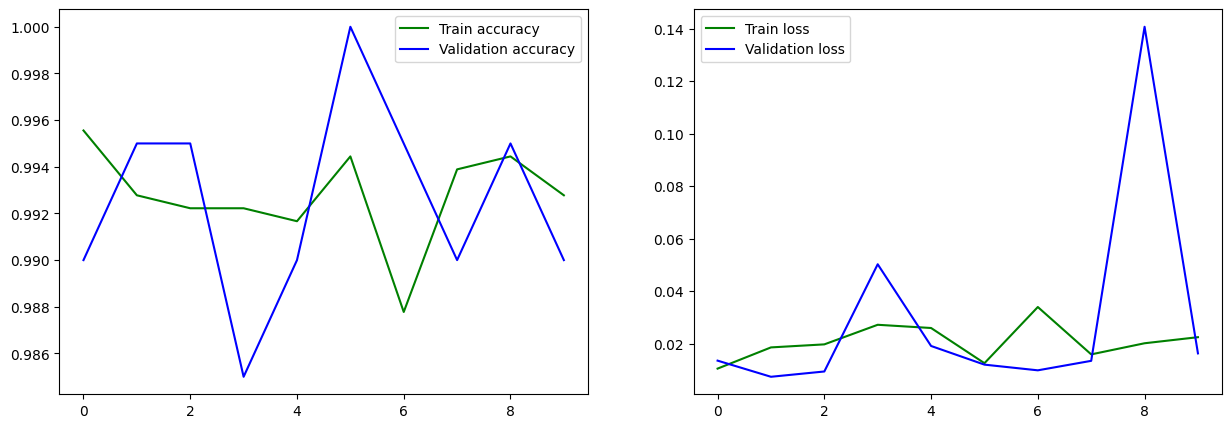

In [22]:
training(10, 300, 0.007)

Сохраняем результаты в csv

In [23]:
bear_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        bear_probs += list(zip(list(fileid), preds_list))
bear_probs.sort(key=lambda x: int(x[0]))
bear_probs[:10]

[(tensor(0), 4.858576176047791e-06),
 (tensor(0), 0.0002454460191074759),
 (tensor(0), 3.6584653571480885e-05),
 (tensor(0), 0.0006085725035518408),
 (tensor(0), 9.311336725659203e-06),
 (tensor(0), 0.10570521652698517),
 (tensor(0), 5.994369348627515e-05),
 (tensor(0), 4.985247414879268e-06),
 (tensor(0), 3.2954914786387235e-05),
 (tensor(0), 0.0002508184697944671)]

In [24]:
idx = list(i for i in range(len(bear_probs)))
prob = list(map(lambda x: x[1], bear_probs))

In [62]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('final.csv',index=False)
submission

,id,label
0,0,0.000005
1,1,0.000245
2,2,0.000037
3,3,0.000609
4,4,0.000009
...,...,...
195,195,0.996631
196,196,1.000000
197,197,0.992938
198,198,0.999877


Сохраняем модель

In [26]:
torch.save(model.state_dict(), os.path.join("K:\Pyth\PLab1\Lab5", "model_weight.pt"))

Инициализируем модель по новой

In [27]:
mymodel = CNN()
mymodel.load_state_dict(torch.load(os.path.join("K:\Pyth\PLab1\Lab5", "model_weight.pt")))

<All keys matched successfully>

Запуск модели

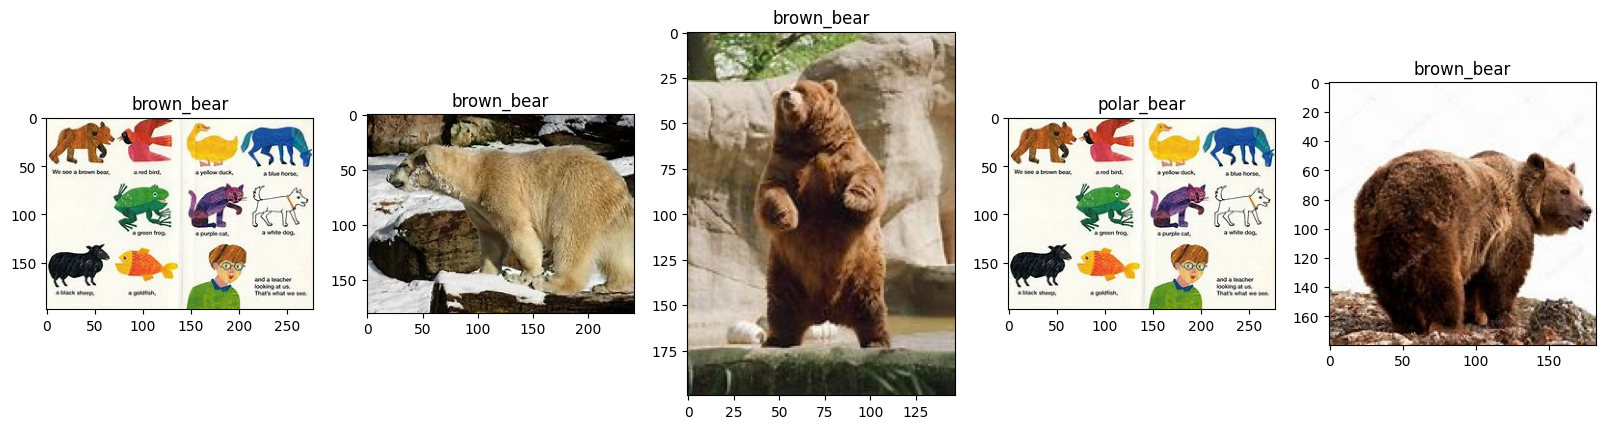

In [60]:
id_list = []
class_ = {0: 'brown_bear', 1: 'polar_bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)